In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Load and explore the dataset
df = pd.read_csv('interview_practice_dataset.csv')
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.strftime('%B')

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"\nRegions: {df['region'].unique()}")
print(f"\nBasic Statistics:")
print(df[['sales', 'marketing_spend', 'website_visits']].describe())
print(f"\nMissing values:")
print(df.isnull().sum())


Dataset Overview:
Shape: (300, 7)

Date range: 2023-01-01 00:00:00 to 2023-10-27 00:00:00

Regions: ['East' 'South' 'West' 'North']

Basic Statistics:
            sales  marketing_spend  website_visits
count  300.000000       300.000000      300.000000
mean   244.066600        49.785033     1215.940000
std     29.722231         9.616042      199.348143
min    156.430000        25.280000      660.000000
25%    224.705000        42.955000     1085.000000
50%    243.825000        49.810000     1208.000000
75%    262.222500        56.162500     1342.000000
max    352.680000        80.790000     1726.000000

Missing values:
date               0
sales              0
marketing_spend    0
website_visits     0
region             0
month              0
month_name         0
dtype: int64


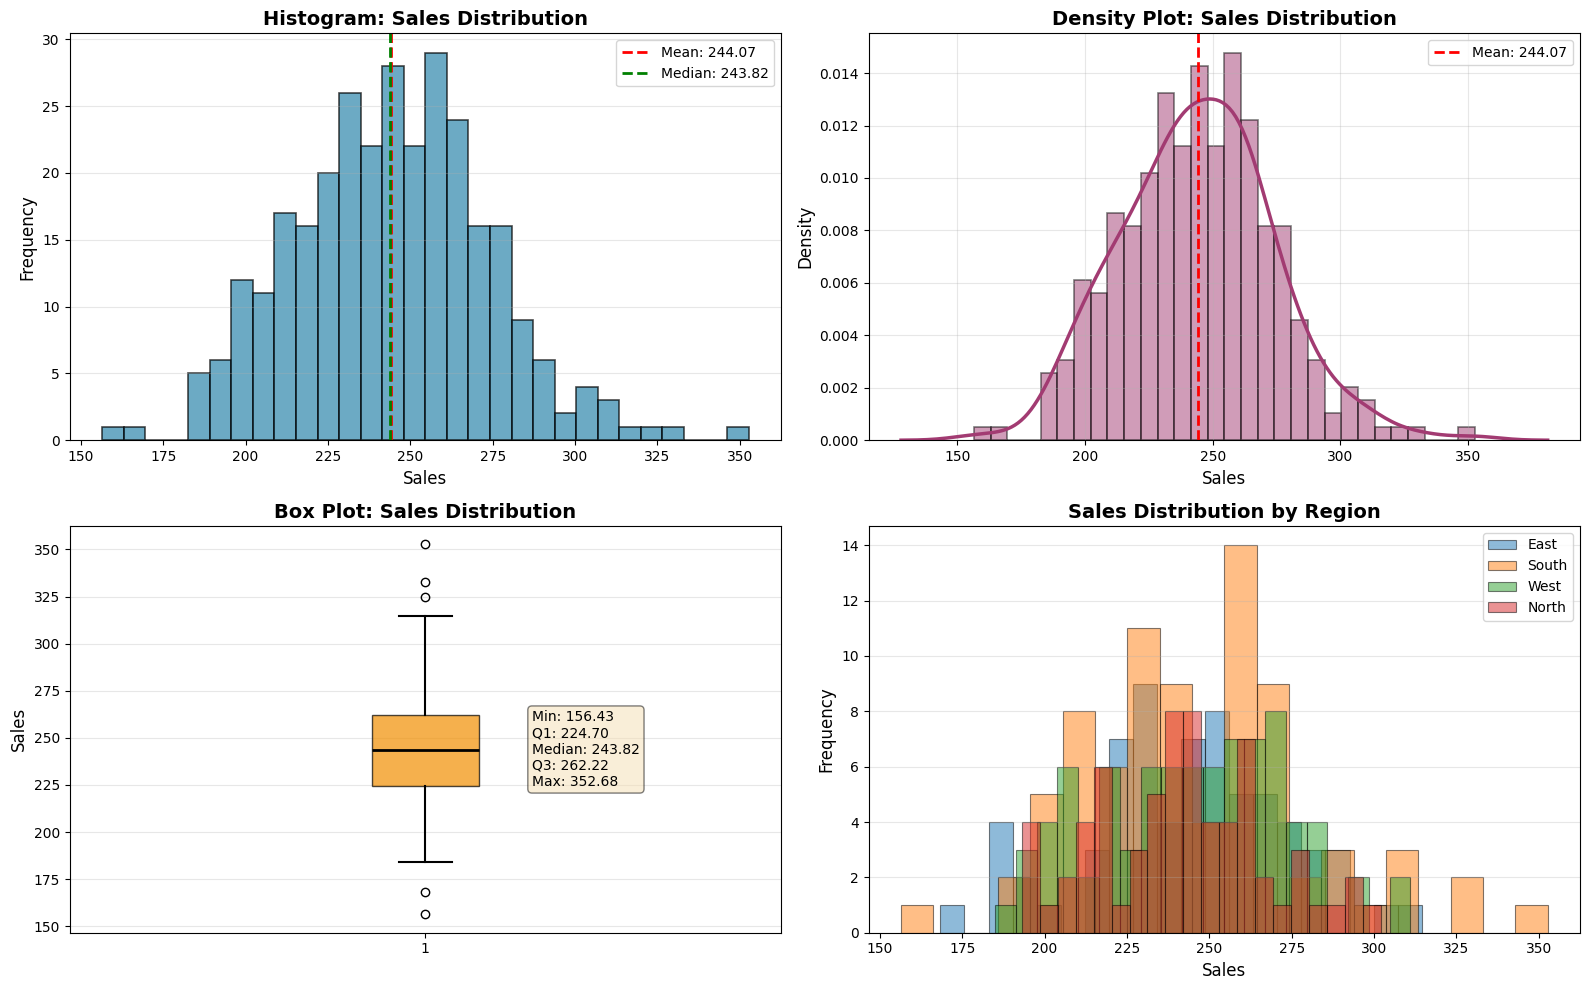

Sales Distribution Statistics:
Mean: 244.07
Median: 243.82
Std Deviation: 29.72
Skewness: 0.190
Kurtosis: 0.368

Percentiles:
25th: 224.70
50th (Median): 243.82
75th: 262.22
95th: 292.70


In [14]:
# Distribution of Sales
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histogram
axes[0, 0].hist(df['sales'], bins=30, color='#2E86AB', alpha=0.7, edgecolor='black', linewidth=1.2)
axes[0, 0].axvline(df['sales'].mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {df["sales"].mean():.2f}')
axes[0, 0].axvline(df['sales'].median(), color='g', linestyle='--', linewidth=2, label=f'Median: {df["sales"].median():.2f}')
axes[0, 0].set_title('Histogram: Sales Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Sales', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Density Plot (KDE)
axes[0, 1].hist(df['sales'], bins=30, density=True, color='#A23B72', alpha=0.5, edgecolor='black', linewidth=1.2)
sns.kdeplot(data=df, x='sales', ax=axes[0, 1], color='#A23B72', linewidth=2.5)
axes[0, 1].axvline(df['sales'].mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {df["sales"].mean():.2f}')
axes[0, 1].set_title('Density Plot: Sales Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Sales', fontsize=12)
axes[0, 1].set_ylabel('Density', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Box Plot
box_plot = axes[1, 0].boxplot(df['sales'], vert=True, patch_artist=True, 
                               boxprops=dict(facecolor='#F18F01', alpha=0.7),
                               medianprops=dict(color='black', linewidth=2),
                               whiskerprops=dict(color='black', linewidth=1.5),
                               capprops=dict(color='black', linewidth=1.5))
axes[1, 0].set_title('Box Plot: Sales Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Sales', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='y')
# Add statistics text
stats_text = f'Min: {df["sales"].min():.2f}\nQ1: {df["sales"].quantile(0.25):.2f}\nMedian: {df["sales"].median():.2f}\nQ3: {df["sales"].quantile(0.75):.2f}\nMax: {df["sales"].max():.2f}'
axes[1, 0].text(1.15, df['sales'].median(), stats_text, 
                verticalalignment='center', fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Distribution by Region
for region in df['region'].unique():
    region_data = df[df['region'] == region]['sales']
    axes[1, 1].hist(region_data, bins=20, alpha=0.5, label=region, edgecolor='black', linewidth=0.8)
axes[1, 1].set_title('Sales Distribution by Region', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sales', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print distribution statistics
print("Sales Distribution Statistics:")
print(f"Mean: {df['sales'].mean():.2f}")
print(f"Median: {df['sales'].median():.2f}")
print(f"Std Deviation: {df['sales'].std():.2f}")
print(f"Skewness: {df['sales'].skew():.3f}")
print(f"Kurtosis: {df['sales'].kurtosis():.3f}")
print(f"\nPercentiles:")
print(f"25th: {df['sales'].quantile(0.25):.2f}")
print(f"50th (Median): {df['sales'].quantile(0.50):.2f}")
print(f"75th: {df['sales'].quantile(0.75):.2f}")
print(f"95th: {df['sales'].quantile(0.95):.2f}")


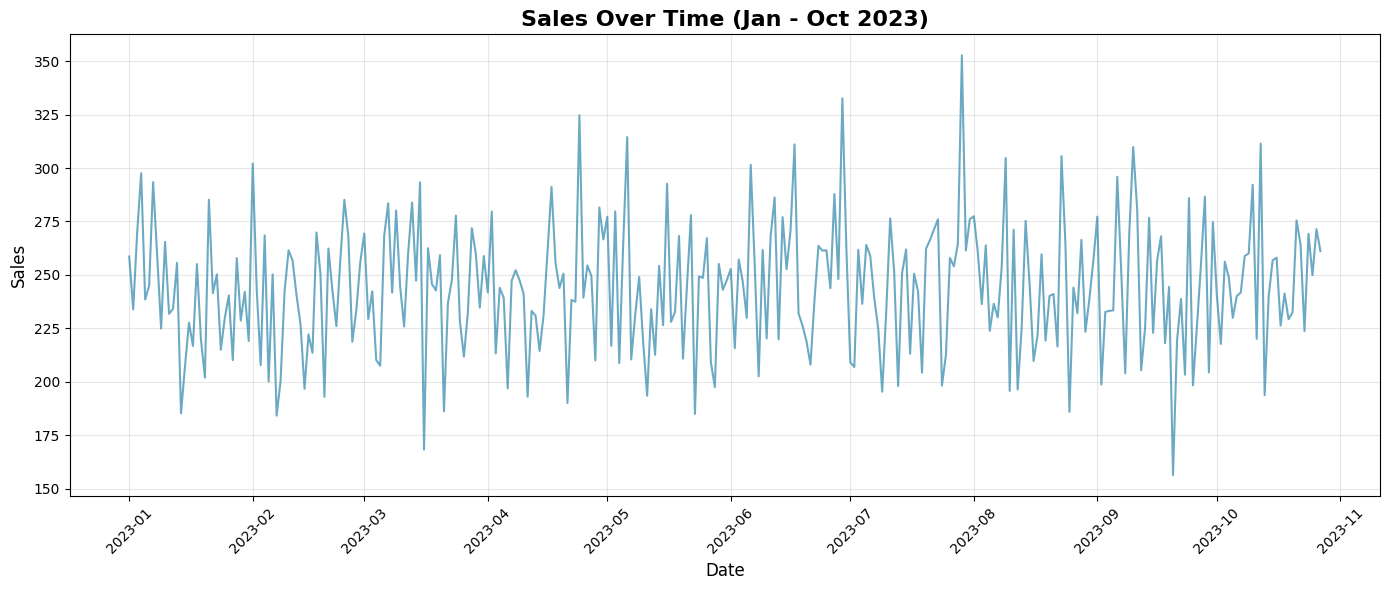

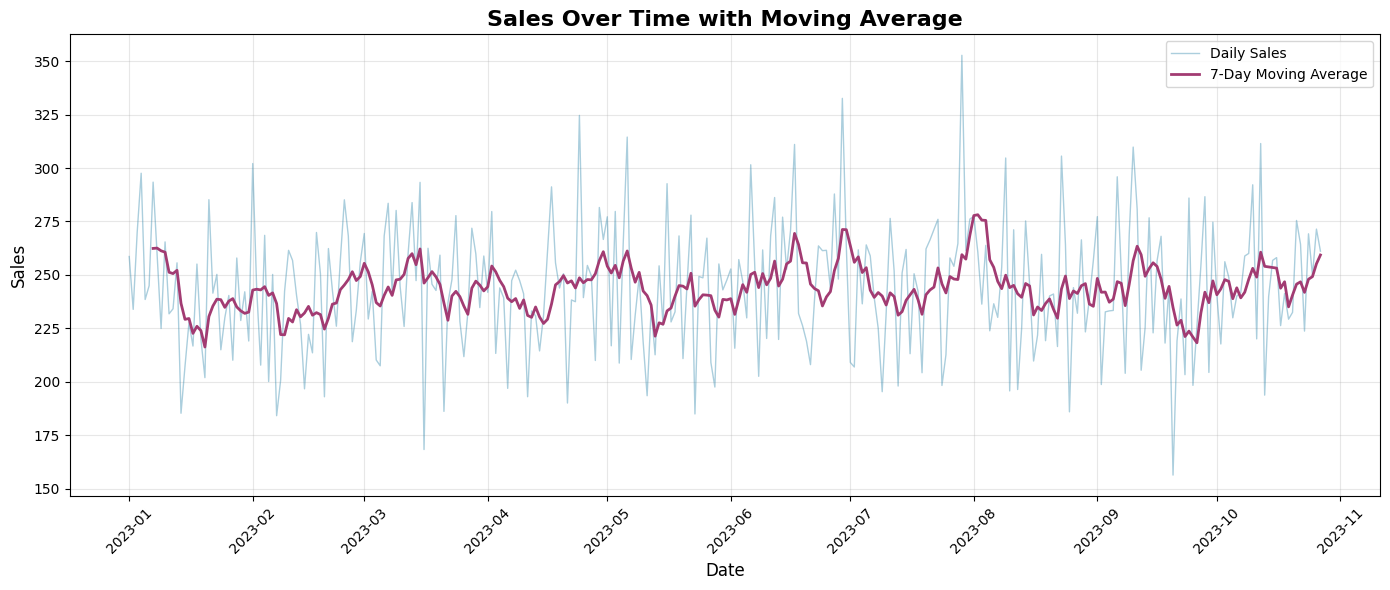

In [7]:
# 1. Time Series: Sales Over Time
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['sales'], linewidth=1.5, alpha=0.7, color='#2E86AB')
plt.title('Sales Over Time (Jan - Oct 2023)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Add moving average
df['sales_ma'] = df['sales'].rolling(window=7).mean()
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['sales'], linewidth=1, alpha=0.4, color='#2E86AB', label='Daily Sales')
plt.plot(df['date'], df['sales_ma'], linewidth=2, color='#A23B72', label='7-Day Moving Average')
plt.title('Sales Over Time with Moving Average', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/9y/5t29fybs4j1cgg17lszqq8340000gn/T/ipykernel_31773/1449225880.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot([df[df['region']==r]['sales'] for r in df['region'].unique()],


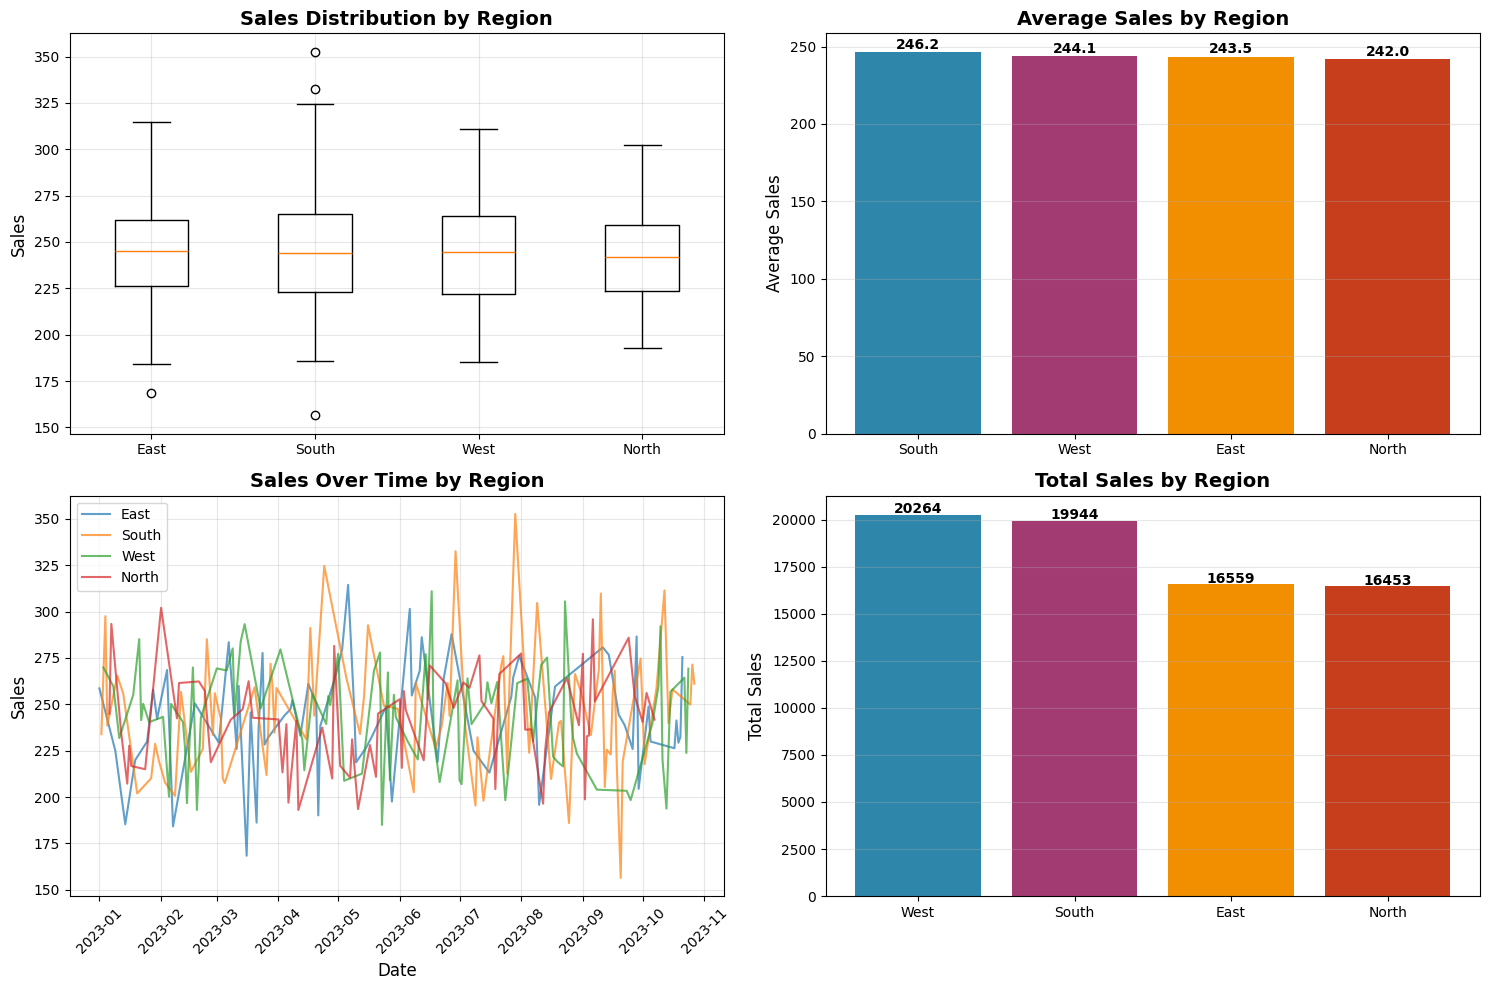

In [8]:
# 2. Regional Sales Comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Box plot by region
axes[0, 0].boxplot([df[df['region']==r]['sales'] for r in df['region'].unique()], 
                   labels=df['region'].unique())
axes[0, 0].set_title('Sales Distribution by Region', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Sales', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# Bar chart: Average sales by region
region_avg = df.groupby('region')['sales'].mean().sort_values(ascending=False)
axes[0, 1].bar(region_avg.index, region_avg.values, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'])
axes[0, 1].set_title('Average Sales by Region', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Average Sales', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(region_avg.values):
    axes[0, 1].text(i, v + 2, f'{v:.1f}', ha='center', fontweight='bold')

# Time series by region
for region in df['region'].unique():
    region_data = df[df['region'] == region].sort_values('date')
    axes[1, 0].plot(region_data['date'], region_data['sales'], label=region, linewidth=1.5, alpha=0.7)
axes[1, 0].set_title('Sales Over Time by Region', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Date', fontsize=12)
axes[1, 0].set_ylabel('Sales', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Total sales by region
region_total = df.groupby('region')['sales'].sum().sort_values(ascending=False)
axes[1, 1].bar(region_total.index, region_total.values, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'])
axes[1, 1].set_title('Total Sales by Region', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Total Sales', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(region_total.values):
    axes[1, 1].text(i, v + 100, f'{v:.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


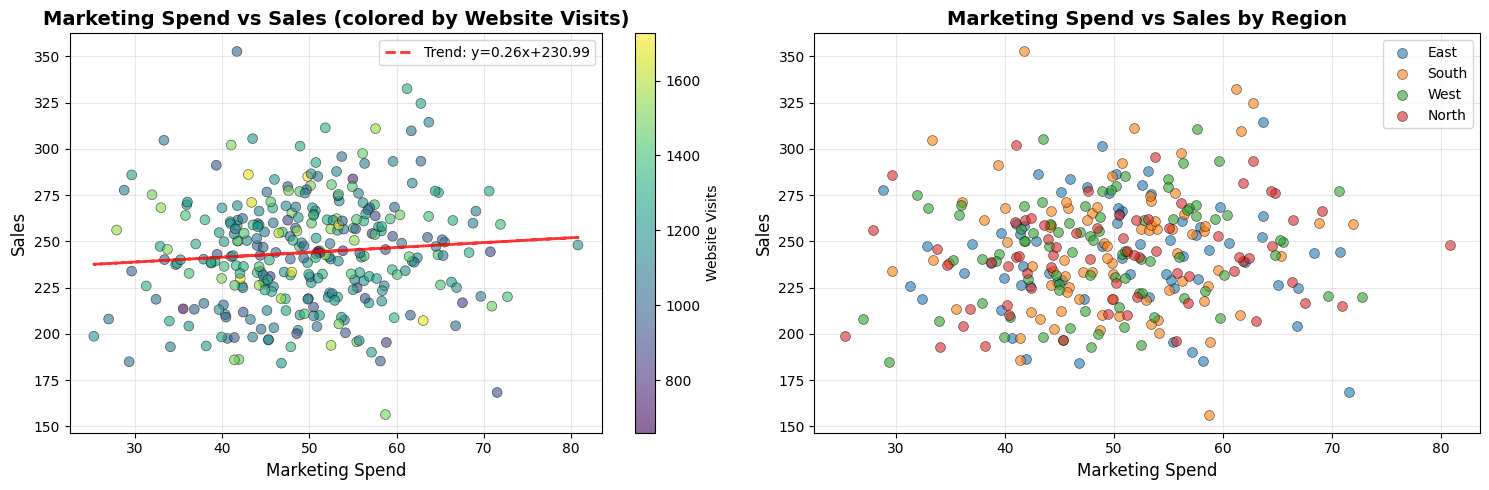


Correlation between Marketing Spend and Sales: 0.085


In [9]:
# 3. Marketing Spend vs Sales Relationship
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot: Marketing Spend vs Sales
scatter = axes[0].scatter(df['marketing_spend'], df['sales'], 
                         c=df['website_visits'], cmap='viridis', 
                         alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Marketing Spend', fontsize=12)
axes[0].set_ylabel('Sales', fontsize=12)
axes[0].set_title('Marketing Spend vs Sales (colored by Website Visits)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='Website Visits')

# Add trend line
z = np.polyfit(df['marketing_spend'], df['sales'], 1)
p = np.poly1d(z)
axes[0].plot(df['marketing_spend'], p(df['marketing_spend']), "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
axes[0].legend()

# Marketing Spend vs Sales by Region
for region in df['region'].unique():
    region_data = df[df['region'] == region]
    axes[1].scatter(region_data['marketing_spend'], region_data['sales'], 
                    label=region, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Marketing Spend', fontsize=12)
axes[1].set_ylabel('Sales', fontsize=12)
axes[1].set_title('Marketing Spend vs Sales by Region', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation
correlation = df[['marketing_spend', 'sales']].corr().iloc[0, 1]
print(f"\nCorrelation between Marketing Spend and Sales: {correlation:.3f}")


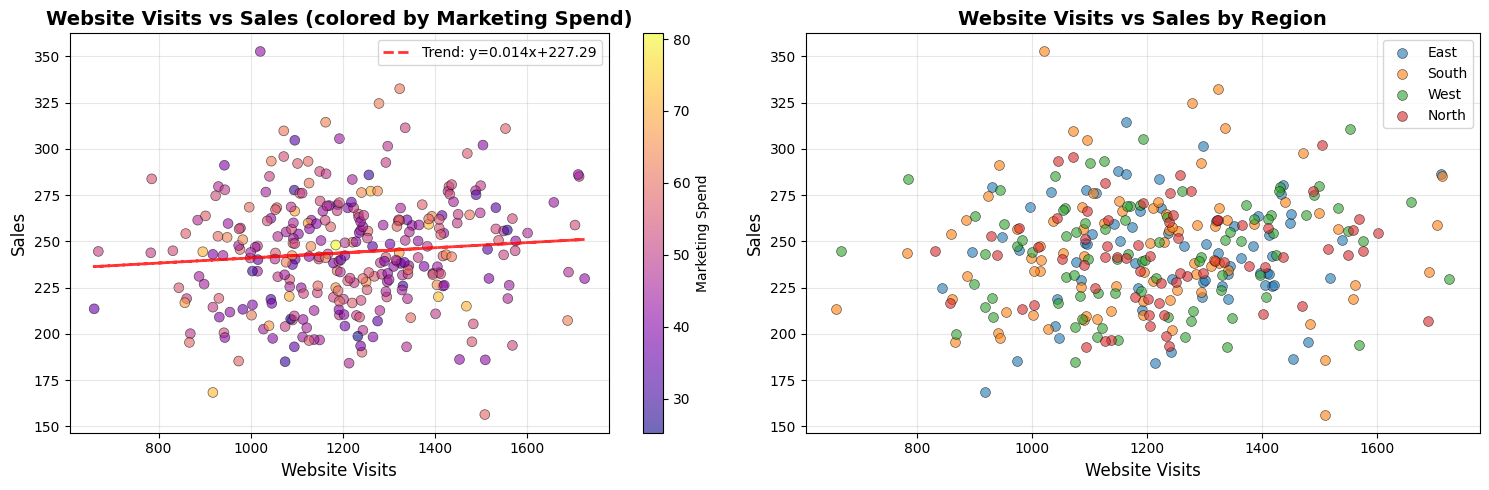


Correlation between Website Visits and Sales: 0.093


In [10]:
# 4. Website Visits vs Sales Relationship
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot: Website Visits vs Sales
scatter = axes[0].scatter(df['website_visits'], df['sales'], 
                         c=df['marketing_spend'], cmap='plasma', 
                         alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Website Visits', fontsize=12)
axes[0].set_ylabel('Sales', fontsize=12)
axes[0].set_title('Website Visits vs Sales (colored by Marketing Spend)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='Marketing Spend')

# Add trend line
z = np.polyfit(df['website_visits'], df['sales'], 1)
p = np.poly1d(z)
axes[0].plot(df['website_visits'], p(df['website_visits']), "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.3f}x+{z[1]:.2f}')
axes[0].legend()

# Website Visits vs Sales by Region
for region in df['region'].unique():
    region_data = df[df['region'] == region]
    axes[1].scatter(region_data['website_visits'], region_data['sales'], 
                    label=region, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Website Visits', fontsize=12)
axes[1].set_ylabel('Sales', fontsize=12)
axes[1].set_title('Website Visits vs Sales by Region', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation
correlation = df[['website_visits', 'sales']].corr().iloc[0, 1]
print(f"\nCorrelation between Website Visits and Sales: {correlation:.3f}")


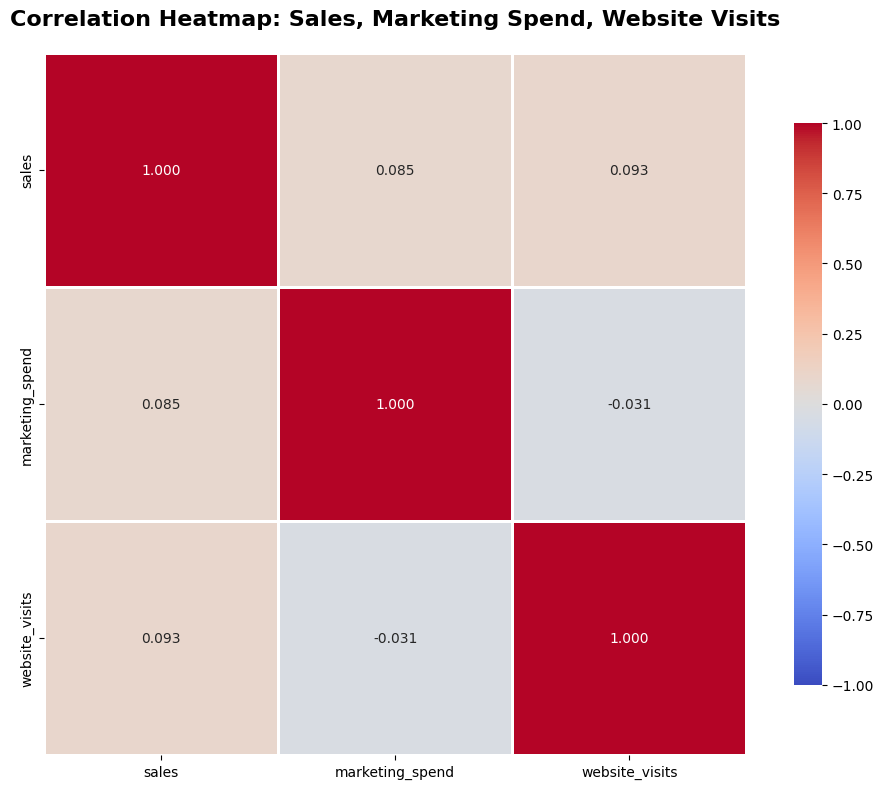

In [11]:
# 5. Correlation Heatmap
import seaborn as sns

plt.figure(figsize=(10, 8))
correlation_matrix = df[['sales', 'marketing_spend', 'website_visits']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=2, cbar_kws={"shrink": 0.8}, 
            fmt='.3f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap: Sales, Marketing Spend, Website Visits', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


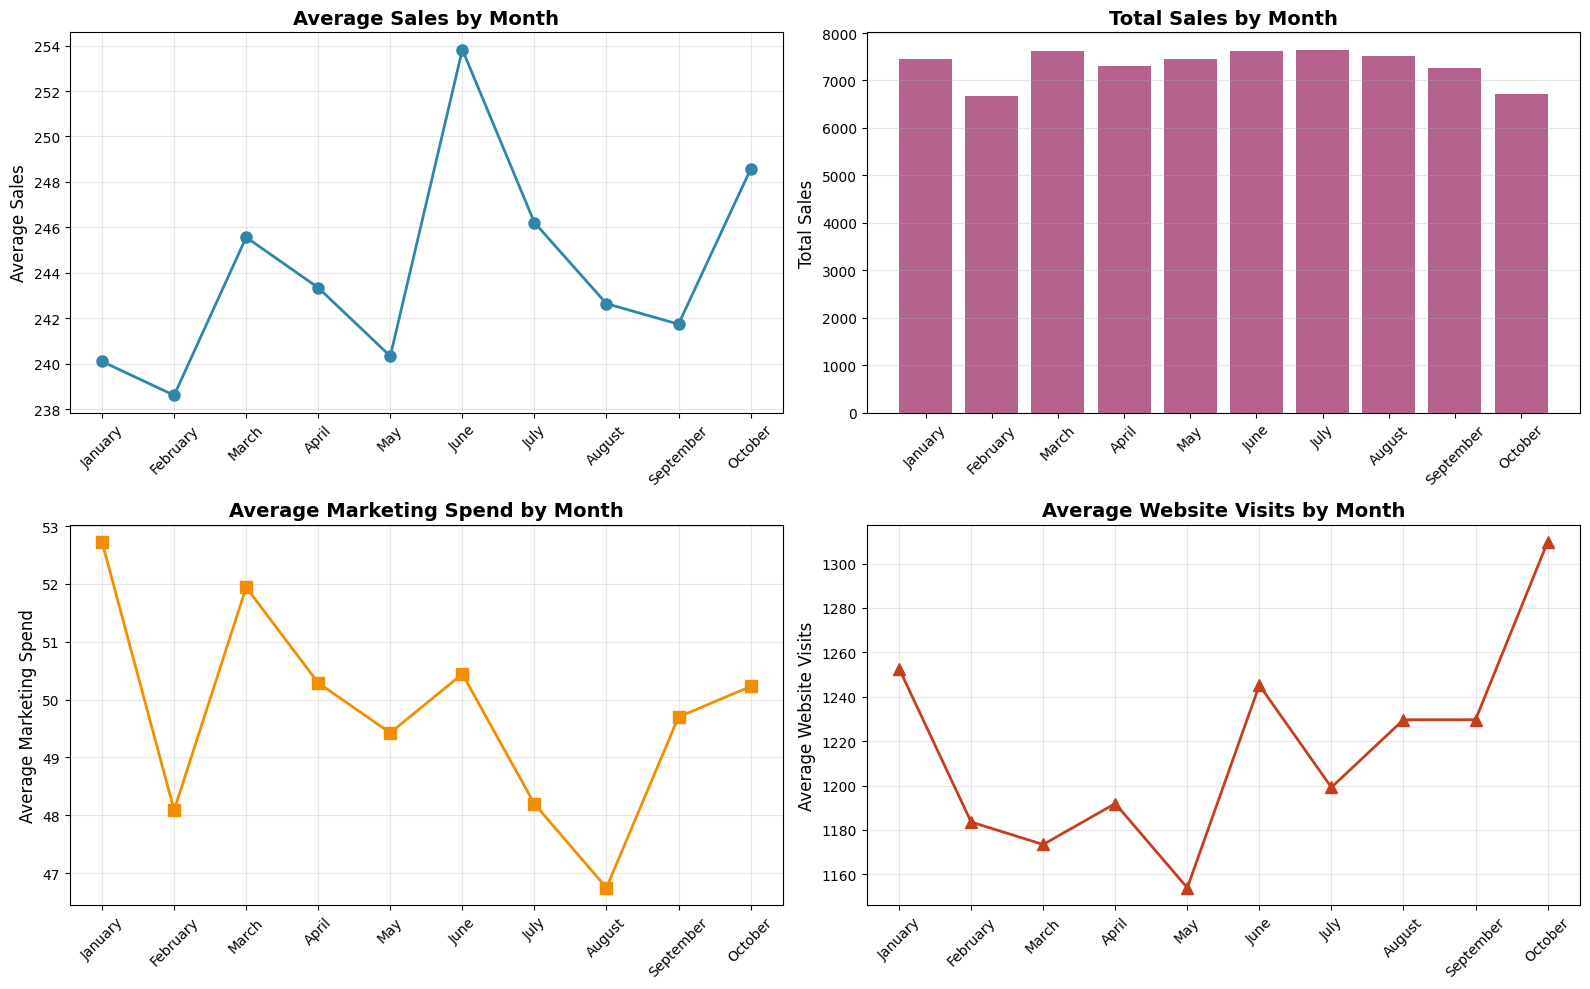

In [12]:
# 6. Monthly Trends Analysis
monthly_stats = df.groupby('month_name').agg({
    'sales': ['mean', 'sum'],
    'marketing_spend': 'mean',
    'website_visits': 'mean'
}).reset_index()
monthly_stats.columns = ['Month', 'Avg_Sales', 'Total_Sales', 'Avg_Marketing', 'Avg_Visits']

# Order months correctly
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October']
monthly_stats['Month'] = pd.Categorical(monthly_stats['Month'], categories=month_order, ordered=True)
monthly_stats = monthly_stats.sort_values('Month')

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Average Sales by Month
axes[0, 0].plot(monthly_stats['Month'], monthly_stats['Avg_Sales'], 
                marker='o', linewidth=2, markersize=8, color='#2E86AB')
axes[0, 0].set_title('Average Sales by Month', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Average Sales', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Total Sales by Month
axes[0, 1].bar(monthly_stats['Month'], monthly_stats['Total_Sales'], 
               color='#A23B72', alpha=0.8)
axes[0, 1].set_title('Total Sales by Month', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Total Sales', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].tick_params(axis='x', rotation=45)

# Average Marketing Spend by Month
axes[1, 0].plot(monthly_stats['Month'], monthly_stats['Avg_Marketing'], 
                marker='s', linewidth=2, markersize=8, color='#F18F01')
axes[1, 0].set_title('Average Marketing Spend by Month', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Average Marketing Spend', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Average Website Visits by Month
axes[1, 1].plot(monthly_stats['Month'], monthly_stats['Avg_Visits'], 
                marker='^', linewidth=2, markersize=8, color='#C73E1D')
axes[1, 1].set_title('Average Website Visits by Month', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Average Website Visits', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


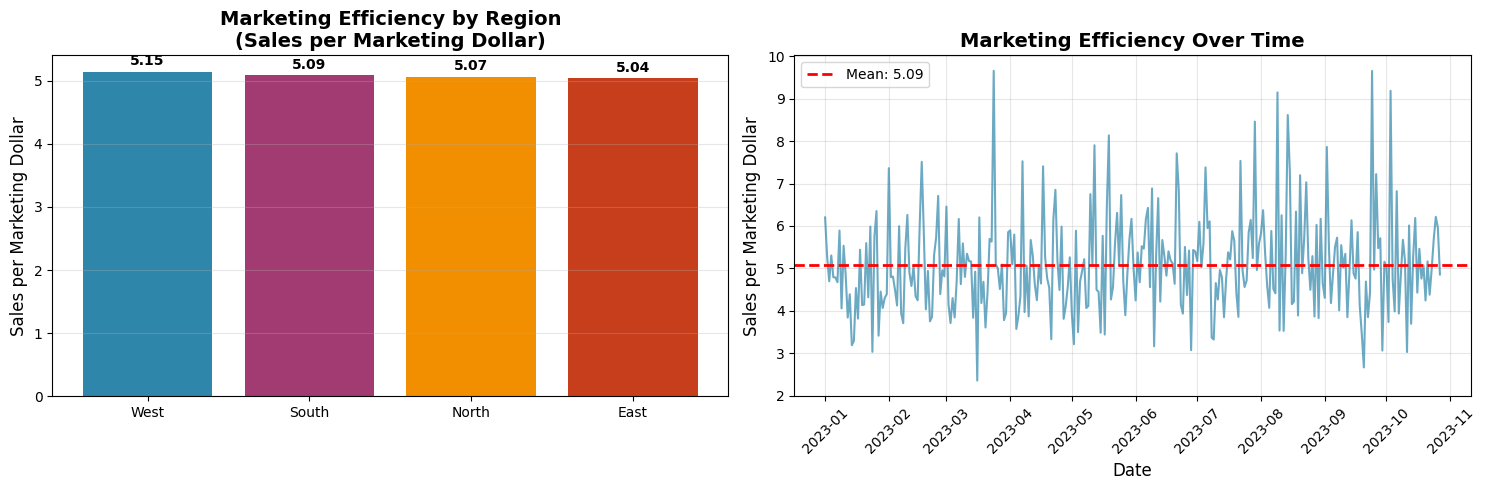


Overall Average Marketing Efficiency: 5.09

Marketing Efficiency by Region:
region
West     5.148923
South    5.086953
North    5.067960
East     5.039216
Name: marketing_efficiency, dtype: float64


In [13]:
# 7. Marketing Efficiency Analysis (Sales per Marketing Dollar)
df['marketing_efficiency'] = df['sales'] / df['marketing_spend']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Marketing Efficiency by Region
region_efficiency = df.groupby('region')['marketing_efficiency'].mean().sort_values(ascending=False)
axes[0].bar(region_efficiency.index, region_efficiency.values, 
            color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'])
axes[0].set_title('Marketing Efficiency by Region\n(Sales per Marketing Dollar)', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Sales per Marketing Dollar', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(region_efficiency.values):
    axes[0].text(i, v + 0.1, f'{v:.2f}', ha='center', fontweight='bold')

# Marketing Efficiency Over Time
df_sorted = df.sort_values('date')
axes[1].plot(df_sorted['date'], df_sorted['marketing_efficiency'], 
             linewidth=1.5, alpha=0.7, color='#2E86AB')
axes[1].axhline(y=df['marketing_efficiency'].mean(), color='r', 
                linestyle='--', linewidth=2, label=f'Mean: {df["marketing_efficiency"].mean():.2f}')
axes[1].set_title('Marketing Efficiency Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Sales per Marketing Dollar', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nOverall Average Marketing Efficiency: {df['marketing_efficiency'].mean():.2f}")
print(f"\nMarketing Efficiency by Region:")
print(df.groupby('region')['marketing_efficiency'].mean().sort_values(ascending=False))
